In [1]:
!pip install tensorflow==2.10.1
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 85.7 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 55.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled t

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import itertools
import tensorflow as tf
from matplotlib import gridspec
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report

2023-11-25 12:33:10.619222: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
hp = {}
hp['image_size'] = 512
hp['num_channels'] = 3
hp['patch_size'] = 64
hp['num_patches'] = (hp['image_size']**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp['patch_size']*hp['patch_size']*hp["num_channels"])
hp['batch_size'] = 32
hp['lr'] = 1e-4
hp["num_epochs"] = 30
hp['num_classes'] = 22
hp["num_layers"] = 12
hp["hidden_dim"] = 512
hp["mlp_dim"] = 3072
hp['num_heads'] = 12
hp['dropout_rate'] = 0.1

In [4]:
model_path = "/kaggle/working/MultiCancerViT .h5"
csv_path = "/kaggle/working/MultiCancerViT .csv"

In [5]:
root_path = "/kaggle/input/multi-cancer/Multi Cancer/"

# Helper Function

In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def get_class_name(root_dir):
        classes_name = []
        r_folder = os.listdir(root_dir)
        for i in r_folder:
            if i != "ALL":
                list_classes = os.listdir(os.path.join(root_dir, i))
                for j in list_classes:
                    classes_name.append(j)
        return classes_name

In [8]:
hp['class_names'] = get_class_name(root_path)

In [53]:
hp['class_names']

['cervix_koc',
 'cervix_dyk',
 'cervix_pab',
 'cervix_sfi',
 'cervix_mep',
 'colon_bnt',
 'colon_aca',
 'lung_aca',
 'lung_bnt',
 'lung_scc',
 'oral_scc',
 'oral_normal',
 'kidney_tumor',
 'kidney_normal',
 'breast_benign',
 'breast_malignant',
 'lymph_fl',
 'lymph_cll',
 'lymph_mcl',
 'brain_tumor',
 'brain_glioma',
 'brain_menin']

In [9]:
def get_image_paths(root_dir, split=0.09):
    image_paths = []
    cancer_fol = os.listdir(root_dir)
    for cancer_name in cancer_fol:
        if cancer_name != "ALL":
            class_names = os.listdir(os.path.join(root_dir, cancer_name))
            for class_name in class_names:
                class_path = os.path.join(root_dir, cancer_name, class_name)
                images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
                image_paths.extend(images)
    
    split_rate = int(len(image_paths) * split)
    train, valid = train_test_split(image_paths, test_size=split_rate, random_state=42)
    train, test = train_test_split(train, test_size=split_rate, random_state=42)
    return train, valid, test

In [10]:
def process_image_label(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp['image_size'], hp['image_size']))
    image = image / 255.0
    
    patch_shape = (hp['patch_size'], hp['patch_size'], hp['num_channels'])
    patches = patchify(image, patch_shape, hp['patch_size'])
    
    #patches = np.reshape(patches, (64, 64, 64, 3))
    #for i in range(64):
    #    cv2.imwrite(f'/kaggle/working/file/image_{i}.png', patches[i])
    patches = np.reshape(patches, hp['flat_patches_shape'])
    patches = patches.astype(np.float32)
    
    #class name
    class_name = path.split("/")[-2]
    class_idx = hp['class_names'].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    
    return patches, class_idx

In [11]:
def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp['num_classes'])
    
    patches.set_shape(hp['flat_patches_shape'])
    labels.set_shape(hp['num_classes'])
    
    return patches, labels

In [12]:
def tf_dataset(images, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse)
    ds = ds.batch(batch_size).prefetch(8)
    return ds

# Data Pipeline

In [13]:
train, valid, test = get_image_paths(root_path)

In [14]:
print(f"Train:{len(train)} - Valid: {len(valid)} - Test:{len(test)}")

Train:90202 - Valid: 9900 - Test:9900


In [15]:
create_dir("/kaggle/working/file")

In [50]:
img = process_image_label(train[2])

## Visualize the image

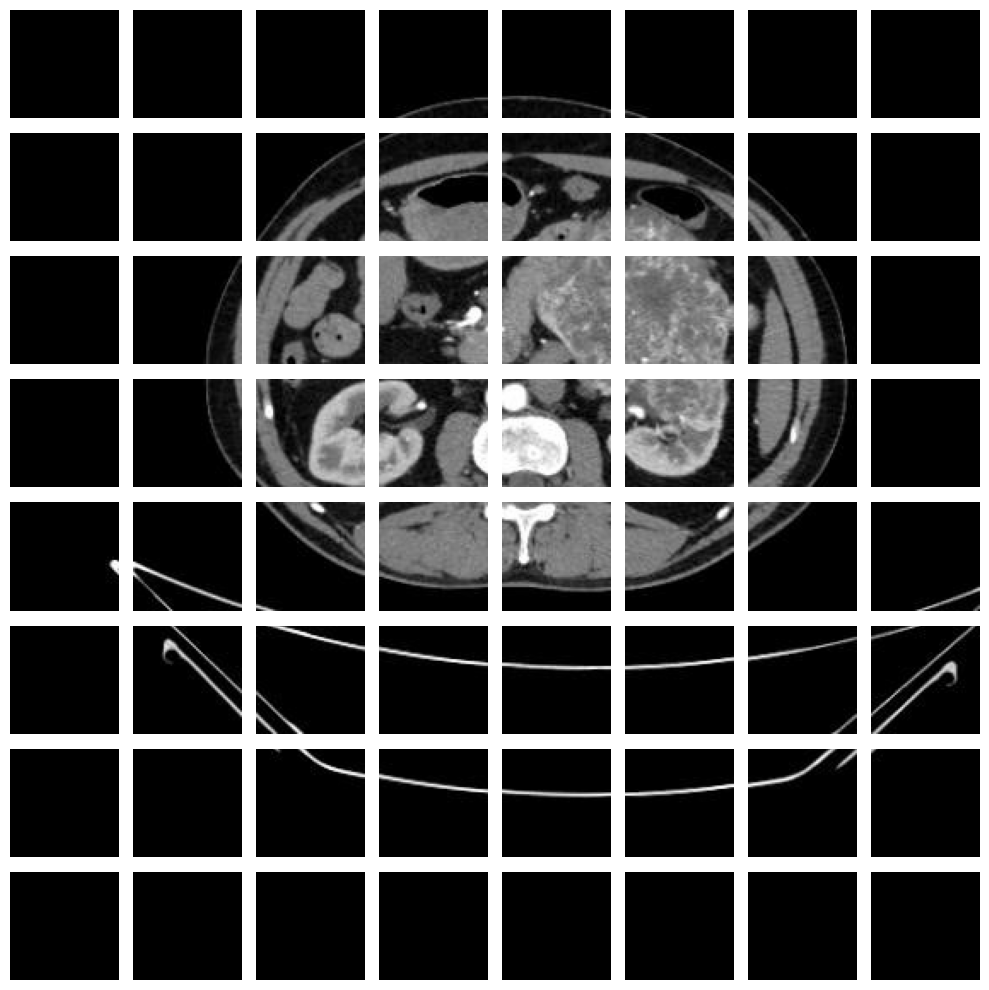

In [51]:
# Path to the folder containing your images
image_folder = "/kaggle/working/file"

# Get a list of image file names
image_files = os.listdir(image_folder)
image_files = [file for file in image_files if file.startswith('image_')]
image_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create a 8x8 grid of subplots
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)

for i, img_file in enumerate(image_files[:64]):
    # Load the image using PIL
    img_path = os.path.join(image_folder, img_file)
    img = Image.open(img_path)
    
    # Create a subplot
    ax = plt.subplot(gs[i])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [16]:
train_ds = tf_dataset(train, batch_size=hp['batch_size'])
valid_ds = tf_dataset(valid, batch_size=hp['batch_size'])
test_ds = tf_dataset(test, batch_size=hp['batch_size'])

In [17]:
for i,j in train_ds:
    print(i.shape, j.shape)
    break

(32, 64, 12288) (32, 22)


# ViT | Model

In [18]:
class ClassToken(layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32), 
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        #reshape
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        #change data type
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls 

In [19]:
def mlp(x, cf):
    x = layers.Dense(cf['mlp_dim'], activation='gelu')(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    x = layers.Dense(cf['hidden_dim'])(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    return x

In [20]:
def transformer_encoder(x, cf):
    skip_1 = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=cf['num_heads'], key_dim=cf['hidden_dim'])(x,x)
    x = layers.Add()([x, skip_1])
    
    skip_2 = x
    x = layers.LayerNormalization()(x)
    x = mlp(x, cf)
    x = layers.Add()([x, skip_2])
    
    return x

In [21]:
def ViT(cf):
    input_shape = (cf['num_patches'], cf['patch_size']*cf['patch_size']*cf['num_channels'])
    inputs = layers.Input(input_shape) #(None, 256, 3072)
    
    #patch + Position embedding
    patch_embed = layers.Dense(cf['hidden_dim'])(inputs) #(None, 256, 768)
    
    positions = tf.range(start=0, limit=cf['num_patches'], delta=1)
    pos_emb = layers.Embedding(input_dim=cf['num_patches'], output_dim=cf['hidden_dim'])(positions) #(256, 768)
    
    embed = patch_embed + pos_emb #(None, 256, 768)
    
    token = ClassToken()(embed)
    x = layers.Concatenate(axis=1)([token, embed]) #(None, 257, 768)
    
    for _ in range(cf['num_layers']):
        x = transformer_encoder(x, cf)
        
    x = layers.LayerNormalization()(x)
    x = x[:, 0, :]
    x = layers.Dense(cf['num_classes'], activation='softmax')(x)
    
    model = Model(inputs, x)
    return model

In [22]:
model = ViT(hp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 12288)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 64, 512)      6291968     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 512)     0           ['dense[0][0]']                  
 da)                                                                                              
                                                                                                  
 class_token (ClassToken)       (None, 1, 512)       512         ['tf.__operators__.add[0][0]'

In [23]:
model.compile(loss='binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(hp['lr'], clipvalue=1.0),
              metrics=['accuracy']
             )

In [24]:
cbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [25]:
model.fit(
        train_ds,
        epochs=100,
        validation_data=valid_ds,
        callbacks=cbacks
    )

Epoch 1/100
2819/2819 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.6729
Epoch 1: val_loss improved from inf to 0.04437, saving model to /kaggle/working/MultiCancerViT .h5
2819/2819 [==============================] - 1825s 642ms/step - loss: 0.0673 - accuracy: 0.6729 - val_loss: 0.0444 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 2/100
2819/2819 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.8245
Epoch 2: val_loss improved from 0.04437 to 0.03631, saving model to /kaggle/working/MultiCancerViT .h5
2819/2819 [==============================] - 1670s 592ms/step - loss: 0.0390 - accuracy: 0.8245 - val_loss: 0.0363 - val_accuracy: 0.8401 - lr: 1.0000e-04
Epoch 3/100
2819/2819 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.8582
Epoch 3: val_loss improved from 0.03631 to 0.02691, saving model to /kaggle/working/MultiCancerViT .h5
2819/2819 [==============================] - 1657s 588ms/step - loss: 0.0320 - accuracy:

KeyboardInterrupt: 

In [26]:
saved_model = ViT(hp)
saved_model.load_weights("/kaggle/working/MultiCancerViT .h5")
saved_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(hp["lr"]),
        metrics=["acc"]
    )
saved_model.evaluate(test_ds)

310/310 [==============================] - 205s 648ms/step - loss: 0.2781 - acc: 0.9151


[0.2780517041683197, 0.9150505065917969]

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues, figsize=(8, 6), save_path='/kaggle/working/file/cm.png'):
    plt.figure(figsize=figsize)  # Set the figure size

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=45)
    plt.yticks(tick_mark, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")

    else:
        print("Confusion Matrix without normalization")

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
    plt.savefig(save_path)

In [28]:
#prediction
prediction = saved_model.predict(test_ds, verbose=0)

In [29]:
#scale the predicted value
np.around(prediction)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
#get the max value 
y_pred_classes = np.argmax(prediction, axis=1)

In [31]:
#function for get labels of test set
def get_test_data_class(test_path):
    names = []
    for i in test_path:
        name = i.split("/")[-2]
        name_idx = hp['class_names'].index(name)
        names.append(name_idx)
    names = np.array(names, dtype=np.int32)
    return names

In [32]:
classes = get_test_data_class(test)

In [33]:
#confusion matrix
cm = confusion_matrix(y_true=classes, y_pred=y_pred_classes)

Confusion Matrix without normalization


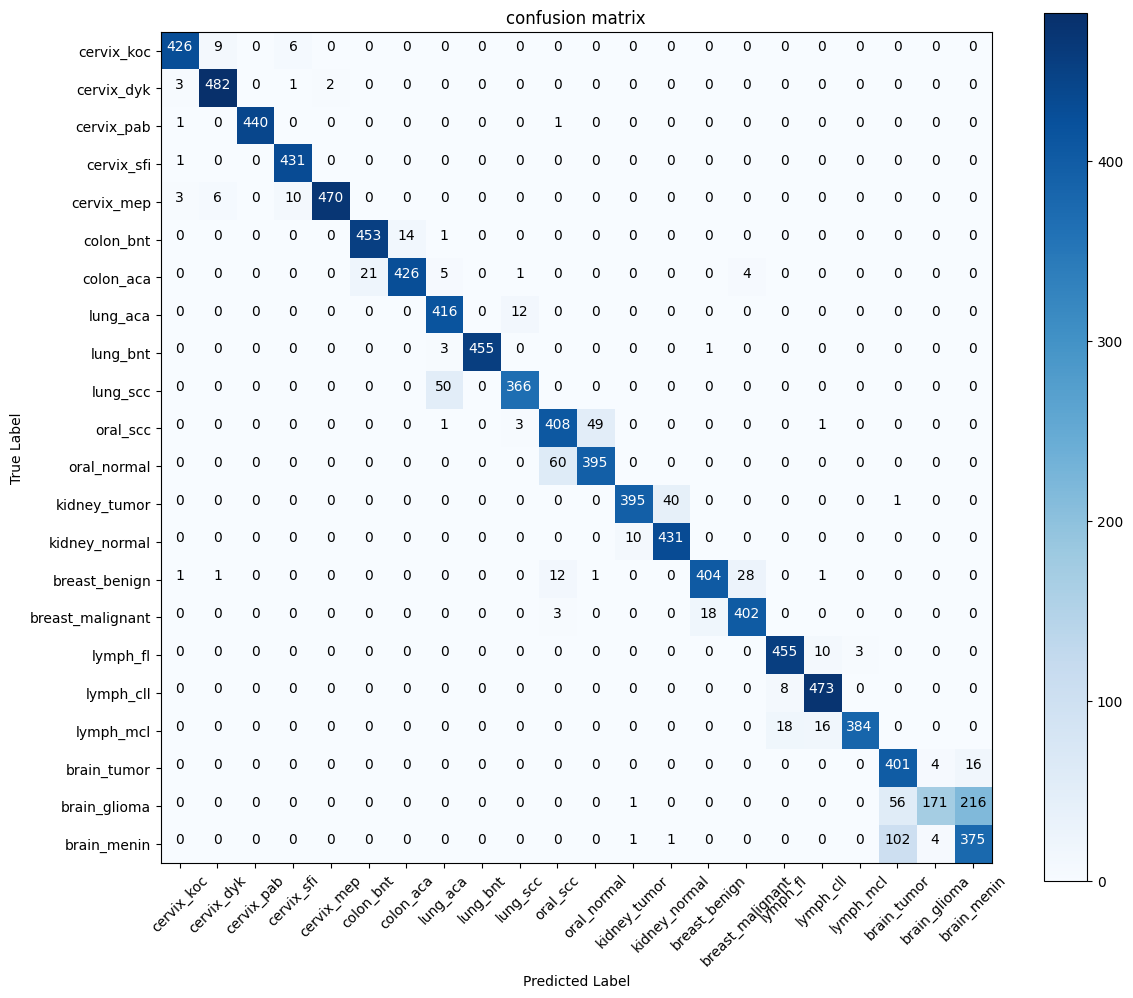

In [48]:
plt_confusion_matrix(cm=cm, classes=hp['class_names'], title="confusion matrix", figsize=(12,10))

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true=classes, y_pred=y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       441
           1       0.97      0.99      0.98       488
           2       1.00      1.00      1.00       442
           3       0.96      1.00      0.98       432
           4       1.00      0.96      0.98       489
           5       0.96      0.97      0.96       468
           6       0.97      0.93      0.95       457
           7       0.87      0.97      0.92       428
           8       1.00      0.99      1.00       459
           9       0.96      0.88      0.92       416
          10       0.84      0.88      0.86       462
          11       0.89      0.87      0.88       455
          12       0.97      0.91      0.94       436
          13       0.91      0.98      0.94       441
          14       0.96      0.90      0.93       448
          15       0.93      0.95      0.94       423
          16       0.95      0.97      0.96       468
          17       0.94    

# Push Model to HuggingFace

In [51]:
from huggingface_hub import push_to_hub_keras

In [49]:
%%capture
!pip install git+https://github.com/huggingface/huggingface_hub.git@main
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [50]:
from huggingface_hub import notebook_login
notebook_login()

In [52]:
push_to_hub_keras(saved_model, 'ErnestBeckham/MulticancerViT')

keras_metadata.pb:   0%|          | 0.00/2.43M [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/782M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

'https://huggingface.co/ErnestBeckham/MulticancerViT/tree/main/'